# Unprecedented_extreme_identification.ipynb

In [36]:
#!/usr/bin/env python
'''File name: Centroids-and-Scatterplot.py
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.04.2018
    Date last modified: 16.04.2018

    ############################################################## 
    Purpos:

    Apply the optimal settings for the region of interest that was
    determined with:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_ExtremeEvent-WeatherTyping.py

    1) Read the PRISM and ERA-Interim data
    2) Calculate the WT centroids
    3) Plot the Centroids
    3) Calculate Eucledian Distances for each day
    4) Plot ED vs. PR accumulation

'''

from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap; bm = Basemap()

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata


def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])# ,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

In [37]:
# ###################################################
# Get the setup for the XWTing
DW_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
Season='Annual' # ['AMJJAS', 'ONDJFM']
iReg=5 #int(sys.argv[1])
Region=DW_Regions[iReg]
ExtremeYear=2007
rgsLableABC=list(string.ascii_lowercase)
Domain=[38,-112,28,-121]

from XWTs_apply import HUC2_XWTs_apply
rgdTime, iMonths, sPlotDir, sDataDir, sSubregionPR, rgsWTvars, VarsFullName,rgsWTfolders, rgrNrOfExtremes, WT_Domains, DomDegreeAdd, Annual_Cycle, SpatialSmoothing, Metrics, Dimensions, FireObs = HUC2_XWTs_apply(Season,Region)
# rgrNrOfExtremes=3

sSubregionPR=sSubregionPR+Region

# create nessesary directories
if not os.path.exists(sDataDir):
    os.makedirs(sDataDir)
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)
sRegion=Region.replace('/','-')

YYYY_stamp=str(rgdTime.year[0])+'-'+str(rgdTime.year[-1])
ss='-'
VarsJoint=ss.join(VarsFullName)
sMonths=ss.join([str(iMonths[ii]) for ii in range(len(iMonths))])
rgiSeasonWT=np.isin(rgdTime.month, iMonths)
rgiYears=np.unique(rgdTime.year)
rgdTime=rgdTime[rgiSeasonWT]
SPLIT=np.where(rgdTime.year < rgiYears[int(len(rgiYears)/2)])[0][-1]
rgdTimeMM = pd.date_range(datetime.datetime(rgdTime.year[0], rgdTime.month[0], rgdTime.day[0],0), end=datetime.datetime(rgdTime.year[-1], rgdTime.month[-1], rgdTime.day[-1],0), freq='m')

sPlotDir=sPlotDir+sRegion+'/'
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)

print( str(rgrNrOfExtremes)+' EXTREMES')
iNrOfExtremes=rgrNrOfExtremes   # we consider the N highest rainfall extremes


# ###################################################
#       READ IN SHAPEFILE
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))

DomainSizes=['S','M','L','XXL']
DomDegreeAdd=[2,5,10,20]
DomDelta=DomDegreeAdd[DomainSizes.index(WT_Domains)]

Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()

DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)

4 EXTREMES


In [38]:
# ###################################################
#         Read the PRISM grid and data
rgiSrPR=np.array(np.where(rgrSRactP == True))
iLatMaxP=rgiSrPR[0,:].max()+1
iLatMinP=rgiSrPR[0,:].min()
iLonMaxP=rgiSrPR[1,:].max()+1
iLonMinP=rgiSrPR[1,:].min()
rgrPRdata=np.zeros((sum(rgiSeasonWT),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))
    
# ###################################################
#         Read the FIRE observations
from Functions_Extreme_WTs import ExtremeDays
MinDistDD=7 # two extremes should be at least 7 days appart
if FireObs == 'MODIS':
    rgiSrPR=np.array(np.where(rgrSRactP == True))
    iLatMaxP=rgiSrPR[0,:].max()+1
    iLatMinP=rgiSrPR[0,:].min()
    iLonMaxP=rgiSrPR[1,:].max()+1
    iLonMinP=rgiSrPR[1,:].min()
    rgrPRdata=np.zeros((sum(rgiSeasonWT),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

    for mo in range(len(rgdTimeMM)):
        rgiDD=np.where(((rgdTimeMM.year[mo] == rgdTime.year) & (rgdTime.month == rgdTimeMM.month[mo]) & np.isin(rgdTimeMM.month[mo], iMonths)))[0]
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_'+str(rgdTimeMM.year[mo])+'_'+str("%02d" % rgdTimeMM.month[mo])+'_gridded.nc', mode='r')
        rgrPRdata[rgiDD,:,:]=np.squeeze(ncid.variables['BurnedArea'][:,iLatMinP:iLatMaxP,iLonMinP:iLonMaxP])
        ncid.close()
    rgrPRdata[rgrPRdata<0] = np.nan

    rgiSRgridcells=rgrSRactP[iLatMinP:iLatMaxP,iLonMinP:iLonMaxP].astype('int')
    rgrPRrecords=np.sum(rgrPRdata[:,(rgiSRgridcells==1)], axis=(1))
    rgiExtrTrain=ExtremeDays(rgrPRrecords,iNrOfExtremes,MinDistDD)
    rgiExtremeDays=rgdTime[rgiExtrTrain]
    
#     rgrPReval=np.nanmean(rgrPRdata[:,(rgiSRgridcells == 1)], axis=(1))
#     rgiExtremePR=ExtremeDays(rgrPReval,iNrOfExtremes,MinDistDD)
#     rgiExtremeDays=rgdTime[rgiExtremePR]
elif FireObs == 'Parks':
    SheanDataDir='/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Sean_Parks/SubRegion_DailyBurnedArea/'
    FILE=SheanDataDir+DW_Regions[iReg]+'.txt'
    rgrPRrecords=np.array(pd.read_csv(FILE, delim_whitespace=True, header = None))[:,0]

    rgiExtrTrain=ExtremeDays(rgrPRrecords,iNrOfExtremes,MinDistDD)
    rgiExtremeDays=rgdTime[rgiExtrTrain]

In [39]:
rgiExtremeDays

DatetimeIndex(['2007-10-22', '2003-10-26', '2002-08-03', '2012-05-25'], dtype='datetime64[ns]', freq=None)

In [40]:
# ###################################################
#         Read the ERA-Interim grid and data

from Functions_Extreme_WTs import ReadERA5
DailyVarsOrig, LonWT, LatWT=ReadERA5(grWTregion,        # shapefile with WTing region
                                     rgdTime,           # time period for WTing
                                     iMonths,           # list of months that should be considered
                                     rgsWTfolders,      # directories containing WT files
                                     rgsWTvars)         # netcdf variable names of WT variables

        Read ERA-5 year: 2001
        Read ERA-5 year: 2002
        Read ERA-5 year: 2003
        Read ERA-5 year: 2004
        Read ERA-5 year: 2005
        Read ERA-5 year: 2006
        Read ERA-5 year: 2007
        Read ERA-5 year: 2008
        Read ERA-5 year: 2009
        Read ERA-5 year: 2010
        Read ERA-5 year: 2011
        Read ERA-5 year: 2012
        Read ERA-5 year: 2013
        Read ERA-5 year: 2014
        Read ERA-5 year: 2015
        Read ERA-5 year: 2016
        Read ERA-5 year: 2017
        Read ERA-5 year: 2018
        Read ERA-5 year: 2019


In [41]:
# loop over split sample statistics
TRAIN=(rgdTime.year != ExtremeYear)
TEST=(rgdTime.year == ExtremeYear)

iNrOfExtremes=3

XWT_output=XWT(DailyVarsOrig[TRAIN,:],
            DailyVarsOrig[TEST,:],
            rgrPRrecords[TRAIN],
            rgrPRrecords[TEST],
            rgdTime[TRAIN],
            rgdTime[TEST],
            iNrOfExtremes,
            SpatialSmoothing)

### Plotting

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/San_Diego/Unpresedented_Extreme_Witch-Fire.pdf


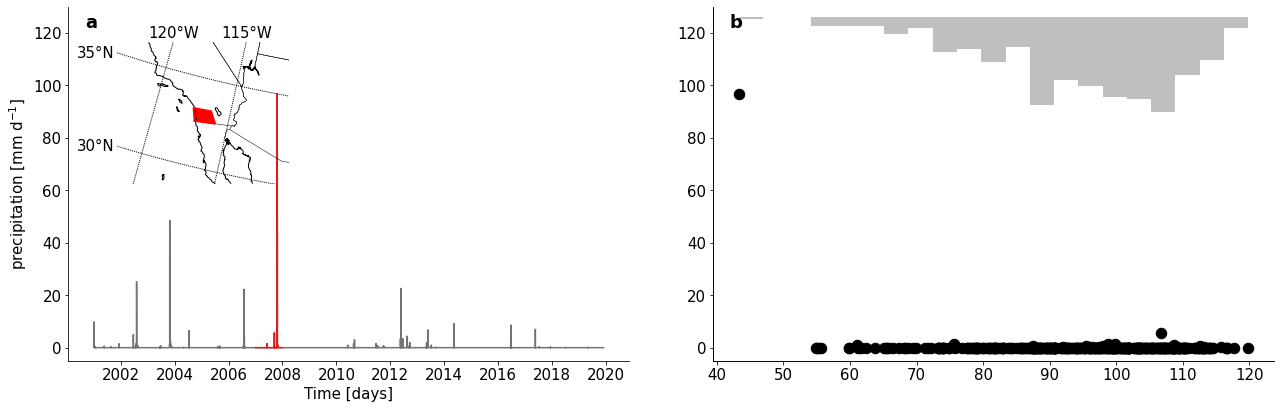

In [42]:
fig = plt.figure(figsize=(18, 6))
plt.rcParams.update({'font.size': 15})

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.06, right=0.99,
           bottom=0.15, top=0.97,
           wspace=0.15, hspace=0.10)

# Timeline
ax = plt.subplot(gs1[0,0])
plt.plot(rgdTime,rgrPRrecords, c='#737373')
plt.plot(rgdTime[TEST],rgrPRrecords[TEST], c='#e31a1c')
ax.set_ylabel('precipitation [mm d$^{-1}$]')
ax.set_xlabel('Time [days]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim((-5,130))

ax.text(0.03,0.98, rgsLableABC[0] , ha='left',va='top', \
                 transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=18, weight='bold')
# plot map inlay
rect = [-0.05,0.5,0.58,0.4]
axI = add_subplot_axes(ax,rect)
plt.axis('off')
m = Basemap(llcrnrlon=Domain[3],llcrnrlat=Domain[2],urcrnrlon=Domain[1],urcrnrlat=Domain[0], projection='lcc',
            lat_1=33,lat_2=45,lon_0=-95,resolution='i')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# highligth shape file
# m.readshapefile(sSubregionPR,'Houston_Harris_County_fin', drawbounds = False)
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
# add shapefile of catchment
XX,YY=m(ctr[:,0], ctr[:,1])
m.plot(XX,YY, c='r', lw=2)
axI.fill(XX,YY, c='r', alpha=1)

m.drawparallels(np.arange(-90.,120.,5.),labels=[True,False,True,False])
m.drawmeridians(np.arange(0.,360.,5.),labels=[True,False,True,False])

# Scatter Plot
ax = plt.subplot(gs1[0,1])

EventStartDay=datetime.datetime(2017, 8, 25,0)
day_of_year = EventStartDay.timetuple().tm_yday
EventDuration=5

# PW_ERA=np.mean(DailyVarsOrig[:,:,:,VarsFullName.index('PW')], axis=(1,2)); mi=20 ; ma=50
# PW_ERA=np.array([rgdTime[dd].timetuple().tm_yday for dd in range(len(rgdTime))]); mi=0 ; ma=364

plt.scatter(XWT_output['grEucledianDist'],rgrPRrecords[TEST], s=110, cmap='coolwarm', c='k') #, vmin=mi, vmax=ma, c=PW_ERA[TEST]
# plt.scatter(XWT_output['grEucledianDist'][day_of_year:day_of_year+EventDuration],
#             rgrPRrecords[TEST][day_of_year:day_of_year+EventDuration], marker='s', s=120,
#             c=PW_ERA[TEST][day_of_year:day_of_year+EventDuration], cmap='coolwarm', vmin=mi, vmax=ma)
# # label the days of Harvey
# for dd in range(EventDuration):
#     Date=str(EventStartDay+datetime.timedelta(days=dd)).split(' ')[0]
#     plt.text(XWT_output['grEucledianDist'][day_of_year+dd]*1.01,
#             rgrPRrecords[TEST][day_of_year+dd], str(Date),ha='left', va='center')
ax.set_ylim((-5,130))
# ax.set_xlim((18,30.5))
ax.text(0.03,0.98, rgsLableABC[1] , ha='left',va='top', \
                 transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=18, weight='bold')

# add eucledian distance histrogram
import matplotlib.pyplot as plt
ax2 = ax.twinx()
ax2.hist(XWT_output['grEucledianDist'], bins=21, alpha=0.25, color='k')
# ax2.set_xlim(ax.get_xlim())
ax2.set_ylim((160,ax.get_ylim()[0]))
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.tick_params(axis='both', which='both', length=0)
    
# cbar=plt.colorbar(extend='both')
# cbar.set_label('precipitable water [mm]', rotation=90)
# ax.set_ylabel('precipitation [mm d$^{-1}$]')
# ax.set_xlabel('Euclidian distance []')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

sPlotFile=sPlotDir
sPlotName= 'Unpresedented_Extreme_Witch-Fire.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [45]:
SORT=np.argsort(XWT_output['grEucledianDist'])

In [47]:
rgrPRrecords[TEST][SORT]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.20084253,
        0.        ,  1.20189632, 96.71979362,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.50772965,
        0.        ,  0.        ,  0.20064834,  0.        ,  0.        ,
        0.        ,  0.        ,  1.20193318,  0.        ,  0.40067327,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  5.61784697,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
XWT_output['grEucledianDist'],rgrPRrecords[TEST]

In [49]:
1-7/365.

0.9808219178082191